In [23]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error,classification_report

from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance

from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [24]:
train = pd.read_csv('Hotel-A-train.csv')
validation = pd.read_csv('Hotel-A-validation.csv')
test = pd.read_csv('Hotel-A-test.csv')
test.head()

,Reservation-id,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Expected_checkin,Expected_checkout,...,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Use_Promotion,Discount_Rate,Room_Rate
0,62931593,F,52,Latino,Grad,25K --50K,South,City Hotel,11/18/2016,11/19/2016,...,0,HB,No,No,No Deposit,Direct,Yes,Yes,10,153
1,70586099,F,47,Latino,Grad,25K --50K,East,Airport Hotels,11/18/2016,11/19/2016,...,0,FB,No,No,No Deposit,Online,No,No,0,210
2,4230648,F,28,Asian American,Grad,<25K,East,City Hotel,4/28/2017,5/1/2017,...,0,BB,No,No,No Deposit,Agent,No,Yes,5,117
3,25192322,F,65,caucasian,High-School,25K --50K,South,Airport Hotels,11/18/2016,11/20/2016,...,2,FB,No,No,No Deposit,Online,Yes,Yes,10,107
4,80931528,M,45,African American,College,25K --50K,South,City Hotel,11/18/2016,11/20/2016,...,0,BB,No,No,Refundable,Agent,No,No,0,119


In [25]:
test.columns

Index(['Reservation-id', 'Gender', 'Age', 'Ethnicity', 'Educational_Level',
       'Income', 'Country_region', 'Hotel_Type', 'Expected_checkin',
       'Expected_checkout', 'Booking_date', 'Adults', 'Children', 'Babies',
       'Meal_Type', 'Visted_Previously', 'Previous_Cancellations',
       'Deposit_type', 'Booking_channel', 'Required_Car_Parking',
       'Use_Promotion', 'Discount_Rate', 'Room_Rate'],
      dtype='object')

In [38]:
x = validation["Use_Promotion"].value_counts()
print(x)

Yes    2085
No      664
Name: Use_Promotion, dtype: int64


In [10]:
def extract_data(train_data):
    Reservation_ID = train_data.pop("Reservation-id")
    y_train = train_data.pop("Reservation_Status")

    #change y_train to classes for turning this as a classification problem
    y_train = y_train.map({'Check-In':1, 'Canceled':2, 'No-Show':3})

    #calculate no-of check in days and try the possiblities it is weekend or not
    train_data["Expected_checkin_days"] = pd.to_datetime(train_data["Expected_checkout"]) - pd.to_datetime(train_data["Expected_checkin"])
    train_data.pop("Expected_checkout")
    train_data.pop("Expected_checkin")

    train_data.pop("Booking_date")

    ## difference between checkin-day and booked day
    # for age use intervals

    train_data["Gender"] = train_data["Gender"].map({'F':0, 'M':1})
    train_data["Required_Car_Parking"] = train_data["Required_Car_Parking"].map({'No':0, 'Yes':1})
    train_data["Use_Promotion"] = train_data["Use_Promotion"].map({'No':0, 'Yes':1})
    train_data["Booking_channel"] = train_data["Booking_channel"].map({'Online':0, 'Direct':1, 'Agent':2})
    train_data["Deposit_type"] = train_data["Deposit_type"].map({'No Deposit':0, 'Refundable':1, 'Non-Refundable':2})
    train_data["Previous_Cancellations"] = train_data["Previous_Cancellations"].map({'No':0, 'Yes':1})
    train_data["Visted_Previously"] = train_data["Visted_Previously"].map({'No':0, 'Yes':1})
    train_data["Meal_Type"] = train_data["Meal_Type"].map({'BB':0, 'HB':1, 'FB':1})
    train_data["Income"] = train_data["Income"].map({'<25K':0, '25K --50K':1, '50K -- 100K':2, '>100K':3})

    train_data["Ethnicity"] = train_data["Ethnicity"].map({'African American':0, 'caucasian':1, 'Asian American':2, "Latino":3})
    #train_data["Educational_Level"] = train_data["Educational_Level"].map({'College':0, 'High-School':1, 'Mid-School':2, "Grad":3})

    changes=["Country_region","Hotel_Type","Educational_Level"]
    dummies=pd.concat([pd.get_dummies(train_data[col]) for col in changes], axis=1)
    train_data=pd.concat([train_data,dummies],axis=1)

    [train_data.pop(col) for col in changes]

    train_data["Age"] = train_data["Age"]//20
    train_data["Discount_Rate"] = train_data["Discount_Rate"]//5
    train_data["Room_Rate"] = train_data["Room_Rate"]//40
    
    train_data["Expected_checkin_days"] = [int(str(x).split(" ")[0]) for x in train_data["Expected_checkin_days"]]
    
    return Reservation_ID, y_train, train_data


In [11]:
train_id, y_train, train_data = extract_data(train)
val_id, y_val, val_data = extract_data(validation)

In [12]:
train_data.columns

Index(['Gender', 'Age', 'Ethnicity', 'Income', 'Adults', 'Children', 'Babies',
       'Meal_Type', 'Visted_Previously', 'Previous_Cancellations',
       'Deposit_type', 'Booking_channel', 'Required_Car_Parking',
       'Use_Promotion', 'Discount_Rate', 'Room_Rate', 'Expected_checkin_days',
       'East', 'North', 'South', 'West', 'Airport Hotels', 'City Hotel',
       'Resort', 'College', 'Grad', 'High-School', 'Mid-School'],
      dtype='object')

In [13]:
val_data.columns

Index(['Gender', 'Age', 'Ethnicity', 'Income', 'Adults', 'Children', 'Babies',
       'Meal_Type', 'Visted_Previously', 'Previous_Cancellations',
       'Deposit_type', 'Booking_channel', 'Required_Car_Parking',
       'Use_Promotion', 'Discount_Rate', 'Room_Rate', 'Expected_checkin_days',
       'East', 'North', 'South', 'West', 'Airport Hotels', 'City Hotel',
       'Resort', 'College', 'Grad', 'High-School', 'Mid-School'],
      dtype='object')

In [14]:
# train_data = train_data.values
# y_train = y_train.values
# val_data = val_data.values
# y_val = y_val.values

In [15]:
# train_data.columns

In [16]:
# val_data.columns

In [17]:
y_train.values

array([2, 2, 2, ..., 3, 3, 3], dtype=int64)

In [18]:
x = y_train.value_counts()
print(x)

2    4132
1    3775
3    2124
Name: Reservation_Status, dtype: int64


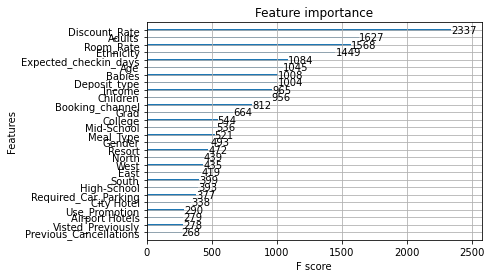

In [19]:
model = XGBClassifier(learning_rate =0.01,n_estimators=1000, max_depth=3, 
                        objective= 'multi:softmax', num_class=3,
                                    seed=30, random_state=7)

model.fit(train_data, y_train)

plot_importance(model)
pyplot.show()

In [20]:
print(model.feature_importances_)

[0.02646022 0.03353737 0.03238139 0.03257995 0.03369527 0.02875418
 0.03099976 0.037504   0.03464881 0.03840709 0.02818538 0.03646029
 0.03993196 0.03397407 0.03252207 0.03637807 0.03880755 0.03104558
 0.0411834  0.0438493  0.03212228 0.02995623 0.03712882 0.03624611
 0.04046881 0.04695316 0.0479861  0.03783279]


In [21]:
y_pred_val = model.predict(val_data)
#predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_val, y_pred_val)
print("Accuracy: %.2f%%" % (accuracy*100.0))


print(classification_report(y_val,y_pred_val))

Accuracy: 37.03%
              precision    recall  f1-score   support

           1       0.60      0.30      0.40      1610
           2       0.27      0.72      0.40       741
           3       0.25      0.00      0.00       398

    accuracy                           0.37      2749
   macro avg       0.38      0.34      0.27      2749
weighted avg       0.46      0.37      0.34      2749



In [22]:
print(y_pred_val)

[1 2 2 ... 1 1 1]


In [23]:
op = {'Reservation-id':val_id,'Reservation_status':y_pred_val}
df = pd.DataFrame(op,columns=['Reservation-id','Reservation_status'])
df.head(20)
#vexport_csv=df.to_csv('prediction_999.csv',index=None,header=True)

,Reservation-id,Reservation_status
0,45716350,1
1,88857401,2
2,16074440,2
3,10992124,1
4,15934351,2
5,58998216,2
6,64307850,2
7,79949146,2
8,95113258,2
9,24700715,1


In [25]:
# thresholds = [0.013,0.014,0.015, 0.016, 0.017, 0.018, 0.020, 0.050]
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(model, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(train_data)
#     #print(select_X_train.columns)
#     # train model
#     selection_model = XGBClassifier(learning_rate =0.001,n_estimators=1000, max_depth=3, 
#                                     colsample_bytree=0.8, objective= 'multi:softmax', num_class=3, nthread=4,
#                                     seed=30, random_state=7)

#     selection_model.fit(select_X_train, y_train)
#     # eval model
#     select_X_test = selection.transform(val_data)
#     y_pred = selection_model.predict(select_X_test)
#     #predictions = [round(value) for value in y_pred]
#     accuracy = accuracy_score(y_val, y_pred)
#     print("Thresh=%.4f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


# print(classification_report(y_val,y_pred))

# #select_test = selection.transform(test_data1)
# #prediction = selection_model.predict(select_test)

# #op = {'Client_ID':index_test,'NEXT_MONTH_DEFAULT':prediction}
# #df = pd.DataFrame(op,columns=['Client_ID','NEXT_MONTH_DEFAULT'])
# #vexport_csv=df.to_csv('prediction_day2_4.csv',index=None,header=True)



In [26]:
def extract_test_data(train_data):
    Reservation_ID = train_data.pop("Reservation-id")
    
    #calculate no-of check in days and try the possiblities it is weekend or not
    train_data["Expected_checkin_days"] = pd.to_datetime(train_data["Expected_checkout"]) - pd.to_datetime(train_data["Expected_checkin"])
    train_data.pop("Expected_checkout")
    train_data.pop("Expected_checkin")

    train_data.pop("Booking_date")

    ## difference between checkin-day and booked day
    # for age use intervals

    train_data["Gender"] = train_data["Gender"].map({'F':0, 'M':1})
    train_data["Required_Car_Parking"] = train_data["Required_Car_Parking"].map({'No':0, 'Yes':1})
    train_data["Use_Promotion"] = train_data["Use_Promotion"].map({'No':0, 'Yes':1})
    train_data["Booking_channel"] = train_data["Booking_channel"].map({'Online':0, 'Direct':1, 'Agent':2})
    train_data["Deposit_type"] = train_data["Deposit_type"].map({'No Deposit':0, 'Refundable':1, 'Non-Refundable':2})
    train_data["Previous_Cancellations"] = train_data["Previous_Cancellations"].map({'No':0, 'Yes':1})
    train_data["Visted_Previously"] = train_data["Visted_Previously"].map({'No':0, 'Yes':1})
    train_data["Meal_Type"] = train_data["Meal_Type"].map({'BB':0, 'HB':1, 'FB':1})
    train_data["Income"] = train_data["Income"].map({'<25K':0, '25K --50K':1, '50K -- 100K':2, '>100K':3})

    train_data["Ethnicity"] = train_data["Ethnicity"].map({'African American':0, 'caucasian':1, 'Asian American':2, "Latino":3})
    #train_data["Educational_Level"] = train_data["Educational_Level"].map({'College':0, 'High-School':1, 'Mid-School':2, "Grad":3})

    changes=["Country_region","Hotel_Type","Educational_Level"]
    dummies=pd.concat([pd.get_dummies(train_data[col]) for col in changes], axis=1)
    train_data=pd.concat([train_data,dummies],axis=1)

    [train_data.pop(col) for col in changes]

    train_data["Age"] = train_data["Age"]//20
    train_data["Discount_Rate"] = train_data["Discount_Rate"]//5
    train_data["Room_Rate"] = train_data["Room_Rate"]//40
    
    train_data["Expected_checkin_days"] = [int(str(x).split(" ")[0]) for x in train_data["Expected_checkin_days"]]
    
    return Reservation_ID, y_train, train_data


In [27]:
test_id, y_test, test_data = extract_test_data(test)

In [28]:
y_pred_test = model.predict(test_data)

In [29]:
op = {'Reservation-id':test_id,'Reservation_status':y_pred_test}
df = pd.DataFrame(op,columns=['Reservation-id','Reservation_status'])
df.head(20)
#vexport_csv=df.to_csv('prediction_211.csv',index=None,header=True)